In [1]:
import numpy as np
import scipy.stats as sps
from tqdm import tqdm
from torchinfo import summary

from utils.utils import *
from utils.noise_gen import *
from utils.training import *
from utils.dataset_loaders import *
from models.basic_models import *

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.io import write_video, write_png
from diffusers import UNet3DConditionModel, DDPMScheduler, DDPMPipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

/home/koltakovmi/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
%reload_ext autoreload
%autoreload 2

Creating dataset and dataloader for UCF-101 and MovingMNIST.

In [2]:
MovMNIST_frame_dataset = MovMNISTFrameDataset("./datasets/moving_mnist_labeled/")
MovMNIST_frame_dataloader = DataLoader(MovMNIST_frame_dataset, shuffle=True, batch_size=72)

dev = "cuda:5"

model_frame, noise_scheduler_frame, optimizer_frame, lr_scheduler_frame, criterion_frame = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=4,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_frame_dataloader),
    device=dev,
    model_type="image",
    use_labels=True,
)

In [2]:
MovMNIST_dataset = MovMNISTDataset("./datasets/moving_mnist_labeled/")
MovMNIST_dataloader = DataLoader(MovMNIST_dataset, shuffle=True, batch_size=2)

dev = "cuda:0"

model_video, noise_scheduler_video, optimizer_video, lr_scheduler_video, criterion_video = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=4,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_dataloader),
    device=dev,
    model_type="video",
    use_labels=True,
)

In [5]:
trainer_image = TrainableDiffusionModel(
    model_ref = model_frame,
    optimizer_ref = optimizer_frame,
    lr_scheduler_ref=lr_scheduler_frame,
    noise_scheduler = noise_scheduler_frame,
    criterion = criterion_frame,
    device="cuda:1",
    model_type="image",
    cross_att_dim=4,
    EMA_start=2500,
)

trainer_image.load_state(base_dir_path="./models/trained/mov_mnist_frames_batch96/", suffix="8000",
                   load_optimizer=False, load_lr_sched=False, load_ema_model=False)

# test_losses = trainer.fit(
#     dataloader = MovMNIST_frame_dataloader,
#     save_path = "./models/trained/mov_mnist_frames_batch96/",
#     num_epochs = 4,
# )

In [3]:
trainer_video = TrainableDiffusionModel(
    model_ref = model_video,
    optimizer_ref = optimizer_video,
    lr_scheduler_ref=lr_scheduler_video,
    noise_scheduler = noise_scheduler_video,
    criterion = criterion_video,
    device="cuda:0",
    model_type="video",
    EMA_start=7500,
    
)

# trainer_video.load_weights_from(trainer_image.model_ref)
# trainer_video.load_weights_from(trainer_image.model_ref, other_type="ema_model")

test_losses = trainer_video.fit(
    dataloader = MovMNIST_dataloader,
    save_path = "./models/trained/test/",
    num_epochs = 4,
)

  0%|                                                                                                                                                                                                                                                   | 1/5000 [00:02<4:08:55,  2.99s/it]

tensor(1.0952, device='cuda:0', grad_fn=<MseLossBackward0>)


OutOfMemoryError: CUDA out of memory. Tried to allocate 160.00 MiB. GPU 0 has a total capacity of 11.76 GiB of which 132.25 MiB is free. Process 3376121 has 170.00 MiB memory in use. Process 827049 has 986.00 MiB memory in use. Process 832669 has 104.00 MiB memory in use. Including non-PyTorch memory, this process has 10.39 GiB memory in use. Of the allocated memory 10.17 GiB is allocated by PyTorch, and 79.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
sampler = TrainableDiffusionModel(
    model_ref = model_video,
    optimizer_ref = optimizer_video,
    lr_scheduler_ref=lr_scheduler_video,
    noise_scheduler = noise_scheduler_video,
    criterion = criterion_video,
    device=dev,
    model_type="video",
    EMA_start=5000,
)

sampler.load_state(base_dir_path="./models/trained/labeled_mov_mnist_mixed_noise/", suffix="last",
                   load_optimizer=False, load_lr_sched=False, load_ema_model=True)
objects = sampler.sample(num_samples=8,
                         video_length=20,
                         prompts = torch.tensor([1, 11, 27, 54, 32, 45, 48, 23]),
                         override_noise_cov=progressive_noise,
                        )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:25<00:00,  5.06s/it]


In [4]:
for i, v in enumerate(objects):
    write_video(
        f"./results/MovMNIST/labeled_video_mixed_noise/prog_noise_{i}.gif",
        v.repeat(3, 1, 1, 1).permute(1, 2, 3, 0),
        fps=7,
    )

GIF muxer supports only a single video GIF stream.


ValueError: [Errno 22] Invalid argument: './results/MovMNIST/labeled_video_mixed_noise/prog_noise_0.gif'; last error log: [gif] GIF muxer supports only a single video GIF stream.

  0%|                                                                                                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.16it/s]


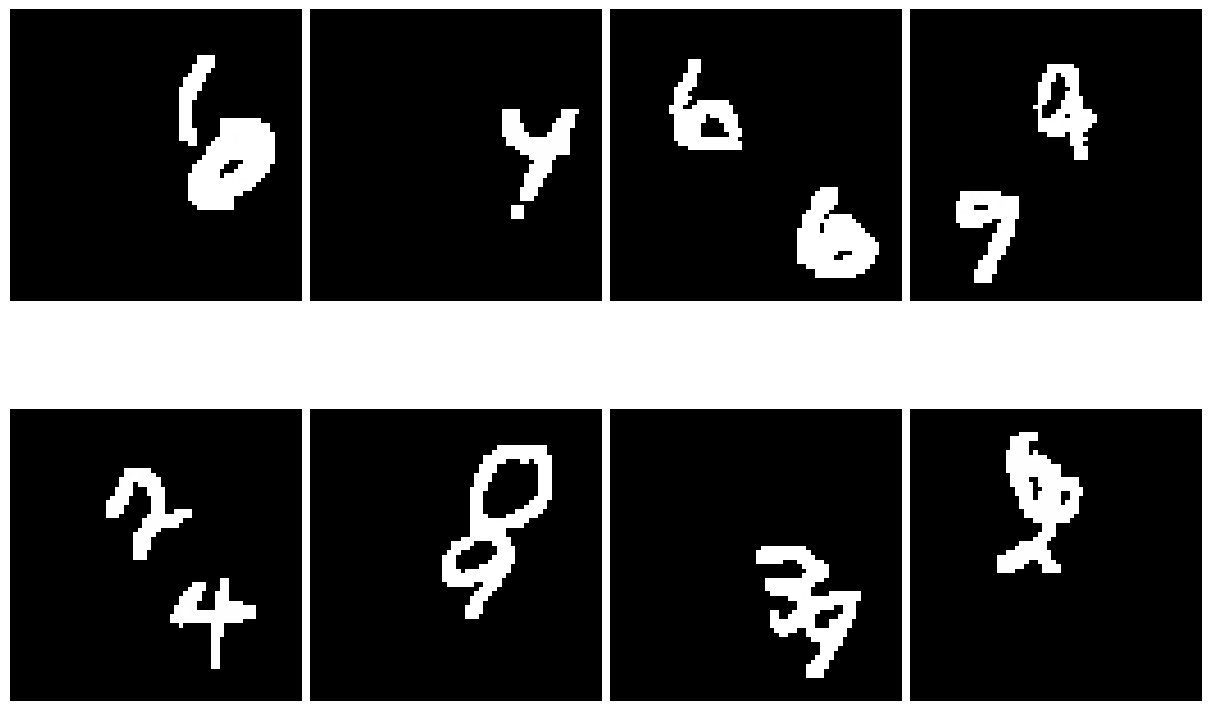

In [4]:
images = sampler.sample(num_samples=8, prompts = torch.tensor([1, 11, 27, 54, 32, 45, 48, 23]))
# images = a.sample.detach().cpu()
# images = ((images.clip(-1, 1) + 1) / 2 * 255).to(torch.uint8)

fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True)
fig.set_size_inches(12, 8)

for i, im in enumerate(images):
    ax[i // 4][i % 4].imshow(im.permute(1, 2, 0), cmap="grey")
    ax[i // 4][i % 4].axis("off")

plt.show()

In [5]:
for i, im in enumerate(images):
    write_png(im, f"results/MovMNIST/labeled_frames/_{i}.png")